In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [10]:
train_dir = './N_C_labeled-images-flipped/train'
test_dir = './N_C_labeled-images-flipped/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [7]:
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 2412 files belonging to 2 classes.
Using 1930 files for training.
Found 2412 files belonging to 2 classes.
Using 482 files for validation.
Found 268 files belonging to 2 classes.


In [5]:
pretrained = VGG16(weights='imagenet', include_top=False)

In [6]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
 activation (Activation)     (None, 1)                 0

In [7]:
cat_list = os.listdir('./N_C_labeled-images-flipped/train/')
cat_list.sort()

lenghts = [len(os.listdir('./N_C_labeled-images-flipped/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['C', 'N']
[236, 2176]
[3.1968734726291563, 1.0535653752852738]


In [8]:
patience = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [9]:
# freeze vgg16
pretrained.trainable = False

model.compile(loss='binary_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
tf.debugging.set_log_device_placement(True)
try:
  # Specify an invalid GPU device
  with tf.device('/device:CPU:0'):
    history = model.fit(
    training_generator,
    steps_per_epoch=2,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1,
    callbacks = [early_stopping])
    
except RuntimeError as e:
  print(e)

Epoch 1/100
2/2 [==============================] - 32s 24s/step - loss: 4.4421 - accuracy: 0.4844 - val_loss: 3.1786 - val_accuracy: 0.9219
Epoch 2/100
2/2 [==============================] - 50s 37s/step - loss: 2.5650 - accuracy: 0.9219 - val_loss: 1.3653 - val_accuracy: 0.8750
Epoch 3/100
2/2 [==============================] - 47s 34s/step - loss: 3.4230 - accuracy: 0.5156 - val_loss: 1.4863 - val_accuracy: 0.8750
Epoch 4/100
2/2 [==============================] - 43s 32s/step - loss: 0.7671 - accuracy: 0.9531 - val_loss: 2.3851 - val_accuracy: 0.9375
Epoch 5/100
2/2 [==============================] - 42s 31s/step - loss: 3.8025 - accuracy: 0.9062 - val_loss: 3.8245 - val_accuracy: 0.9219
Epoch 6/100
2/2 [==============================] - 45s 34s/step - loss: 8.4669 - accuracy: 0.8281 - val_loss: 5.2738 - val_accuracy: 0.8750
Epoch 7/100
2/2 [==============================] - 44s 33s/step - loss: 3.8462 - accuracy: 0.8906 - val_loss: 1.8273 - val_accuracy: 0.9219
Epoch 8/100
2/2 [===

In [12]:
model.save('vgg16_binary_cataract_normal_98.h5')

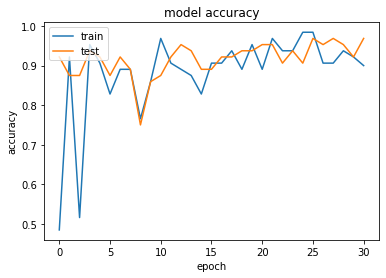

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

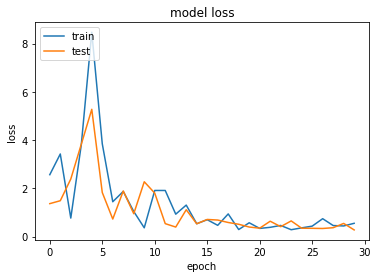

In [14]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model = load_model('vgg16_binary_cataract_normal_98.h5')

In [8]:
## Predict on test data
tf.debugging.set_log_device_placement(True)
try:
  # Specify an invalid GPU device
  with tf.device('/device:CPU:0'):
    y_pred = model.predict(test_generator)
except RuntimeError as e:
  print(e)

9/9 [==============================] - 71s 8s/step


In [10]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [11]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Text(33.0, 0.5, 'Truth')

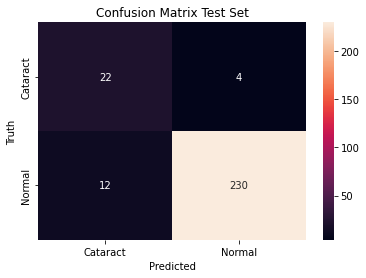

In [15]:
cf_matrix = confusion_matrix(y_real, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Cataract','Normal'])
ax.yaxis.set_ticklabels(['Cataract','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [13]:
print(classification_report(y_real, y_pred, target_names=['Cataract','Normal']))

              precision    recall  f1-score   support

    Cataract       0.65      0.85      0.73        26
      Normal       0.98      0.95      0.97       242

    accuracy                           0.94       268
   macro avg       0.81      0.90      0.85       268
weighted avg       0.95      0.94      0.94       268

